# Basic Text Classification

GOALS
 - Train a binary classifier to perform sentiment analysis on an IMDB dataset

In [46]:
import matplotlib.pyplot as plt 
import os 
import numpy as np 
import re 
import shutil 
import string 

import tensorflow as tf 
from tensorflow.keras import layers, losses

## Sentiment Analysis 

We`ll be doing binary or two class classification, a widely applicable kind of machine learning problem. 

### Download Data 

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz" 
dataset = tf.keras.utils.get_file('aclImdb_v1', url, untar=True, cache_dir='./cache/', cache_subdir='')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 320s 4us/step


In [14]:
dataset_dir = os.path.join(os.path.dirname(dataset),'aclImdb_v1','aclImdb')

In [15]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [40]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 '.DS_Store',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [28]:
sample_file = os.path.join(train_dir, 'pos/164_10.txt')

with open(sample_file) as f: 
    print(f.read())

Don't say I didn't warn you, but your gonna laugh. Probably enough to hurt your stomach. Sure it's got some blood splattering, all in good fun though. So, it's got no budget, who needs a budget when you got a script like this. <br /><br />Take the time and check this out. Well worth a two hour viewing. If everyone could laugh as much as I did during this movie the world would be a much happier place to live.<br /><br />


### Load the Dataset

Next, we will load the data off disk and prepare it into a format suitable for training. To do so, we will use the `text_dataset_from_directory` utility. 

In [29]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below

In [31]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to model.fit. If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.

*NOTE* You can train a model by passing a dataset directly to model.fit

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the class_names property on the dataset.

In [35]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

In [36]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [41]:
test_dir = os.path.join(dataset_dir, 'test')
test_dir

'./cache/aclImdb_v1/aclImdb/test'

In [42]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


## Pre-Processing the Dataset

Now, We will standardize, tokenize and vectorize the data using `TextVectorization` layer

- Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. 
- Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).
- Vectorization refers to converting tokens into numbers so they can be fed into a neural network

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [53]:
def custom_standardization(input_data): 
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

Next, you will create a TextVectorization layer. You set the output_mode to int to create unique integer indices for each token.

*Note* that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [58]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization, 
    max_tokens=max_features, 
    output_mode='int', # create unique integer indices for each token.
    output_sequence_length=sequence_length
)

Next, You will `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

In [59]:
train_text = raw_train_ds.map(lambda x,y : x)
vectorize_layer.adapt(train_text)

2024-12-25 14:36:14.733452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Let's create a function to see the result of using this layer to preprocess some data.

In [67]:
def vectorize_text(text, label): 
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [68]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"A young woman suffers from the delusion that she is a werewolf, based upon a family legend of an ancestor accused of and killed for allegedly being one. Due to her past treatment by men, she travels the countryside seducing and killing the men she meets. Falling in love with a kind man, her life appears to take a turn for the better when she is raped and her lover is killed by a band of thugs. Traumatized again by these latest events, the woman returns to her violent ways and seeks revenge on the thugs," according to the DVD sleeve\'s synopsis.<br /><br />Rino Di Silvestro\'s "La lupa mannara" begins with full frontal, writhing, moaning dance by shapely blonde Annik Borel, who (as Daniella Neseri) mistakenly believes she is a werewolf. The hottest part is when the camera catches background fire between her legs. The opening "flashback" reveals her hairy ancestor was (probably) a lycanthropic creature. Ms. Borel is, unfortunately, not a werewolf; she is merely a very

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [80]:
print('1133', vectorize_layer.get_vocabulary()[1287])
print('359', vectorize_layer.get_vocabulary()[359])
print('499', vectorize_layer.get_vocabulary()[499])
print('vocabulary size', len(vectorize_layer.get_vocabulary()))

1133 silent
359 production
499 theyre
vocabulary size 10000


As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [81]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for Performance

In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the Model 

In [83]:
embedding_dim = 16

In [84]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim), 
    layers.Dropout(0.2), 
    layers.GlobalAveragePooling1D(), 
    layers.Dropout(0.2), 
    layers.Dense(1, activation='sigmoid')
])

In [85]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(loss=losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [87]:
hist = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2024-12-25 15:15:17.583935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5884 - loss: 0.6802 - val_accuracy: 0.7158 - val_loss: 0.6092
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7629 - loss: 0.5752 - val_accuracy: 0.8082 - val_loss: 0.4932
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8221 - loss: 0.4645 - val_accuracy: 0.8416 - val_loss: 0.4193
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8522 - loss: 0.3943 - val_accuracy: 0.8576 - val_loss: 0.3754
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8677 - loss: 0.3484 - val_accuracy: 0.8656 - val_loss: 0.3476
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8817 - loss: 0.3162 - val_accuracy: 0.8700 - val_loss: 0.3292
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.8899 - loss: 0.2913 - val_accuracy: 0.8732 - val_loss: 0.3156
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9008 - loss: 0.2717 - val_accurac

### Evaluate 

In [98]:
history = hist.history
history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [90]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

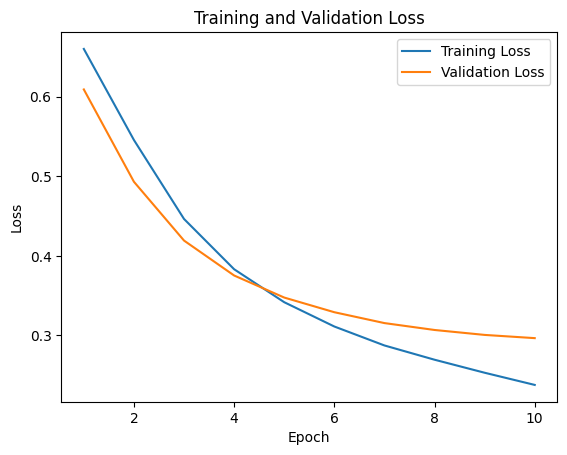

In [97]:
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

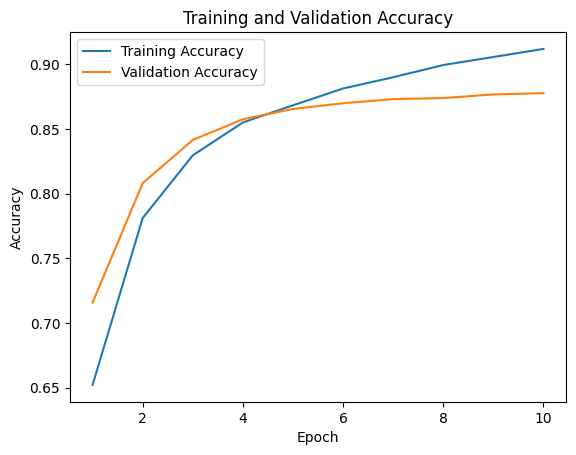

In [96]:
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [99]:
loss, acc = model.evaluate(test_ds)

print('loss', loss)
print('accuracy', acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8687 - loss: 0.3183
loss 0.3170020580291748
accuracy 0.8694800138473511


Woah! An Accuracy of 86%, not bad

Before, We applied the `TextVectorization` layer to the dataset before feeding text to the model. If we want to make our model capable of processing raw strings, we can include this layer inside the model itself. 

In [100]:
new_model = tf.keras.Sequential([
    vectorize_layer, 
    model, 
    layers.Activation('sigmoid')
])

In [106]:
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_8            │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │       160,017 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,017 (625.07 KB)

 Trainable params: 160,017 (625.07 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
new_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [105]:
loss, acc = new_model.evaluate(raw_test_ds)

print('loss', loss)
print('accuracy', acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5013 - loss: 0.5880
loss 0.5884732604026794
accuracy 0.5


In [109]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

new_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


array([[0.63784915],
       [0.5938888 ],
       [0.5731637 ]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for train/test skew.

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.